In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from typing import Dict

import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csr_matrix

import celeri


# Read in data files and do basic processing

In [3]:
# Japan example
command_file_name = "../data/command/japan_command.json"

# Western North America example
# command_file_name = "../data/command/western_north_america_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

[INFO] Read: ../data/command/japan_command.json
[INFO] RUN_NAME: 2022-04-14-17-51-47
[INFO] Write log file: ../runs/2022-04-14-17-51-47/2022-04-14-17-51-47.log
[INFO] Reading data files
[SUCCESS] Read: ../data/segment/japan_segment.csv
[SUCCESS] Read: ../data/block/japan_block.csv
[SUCCESS] Read: ../data/mesh/japan_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

[SUCCESS] Read: ../data/mesh/nankai.msh



Warning: The file contains tag data that couldn't be processed.

[SUCCESS] Read: ../data/mesh/japan.msh



Warning: The file contains tag data that couldn't be processed.

[SUCCESS] Read: ../data/mesh/sagami.msh
[SUCCESS] Read: ../data/station/japan_station.csv
[INFO] No mogi_file_name
[INFO] No sar_file_name


# Get elastic operators and TDE smoothing operators

In [5]:
# Calculate Okada partials for all segments
celeri.get_elastic_operators_okada(operators, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

[INFO] Using precomputed elastic operators


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
operators.rotation_to_slip_rate_to_okada_to_velocities = operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
celeri.get_tde_slip_rate_constraints(meshes, operators)

[INFO] No slip rate constraints


# Plot input data

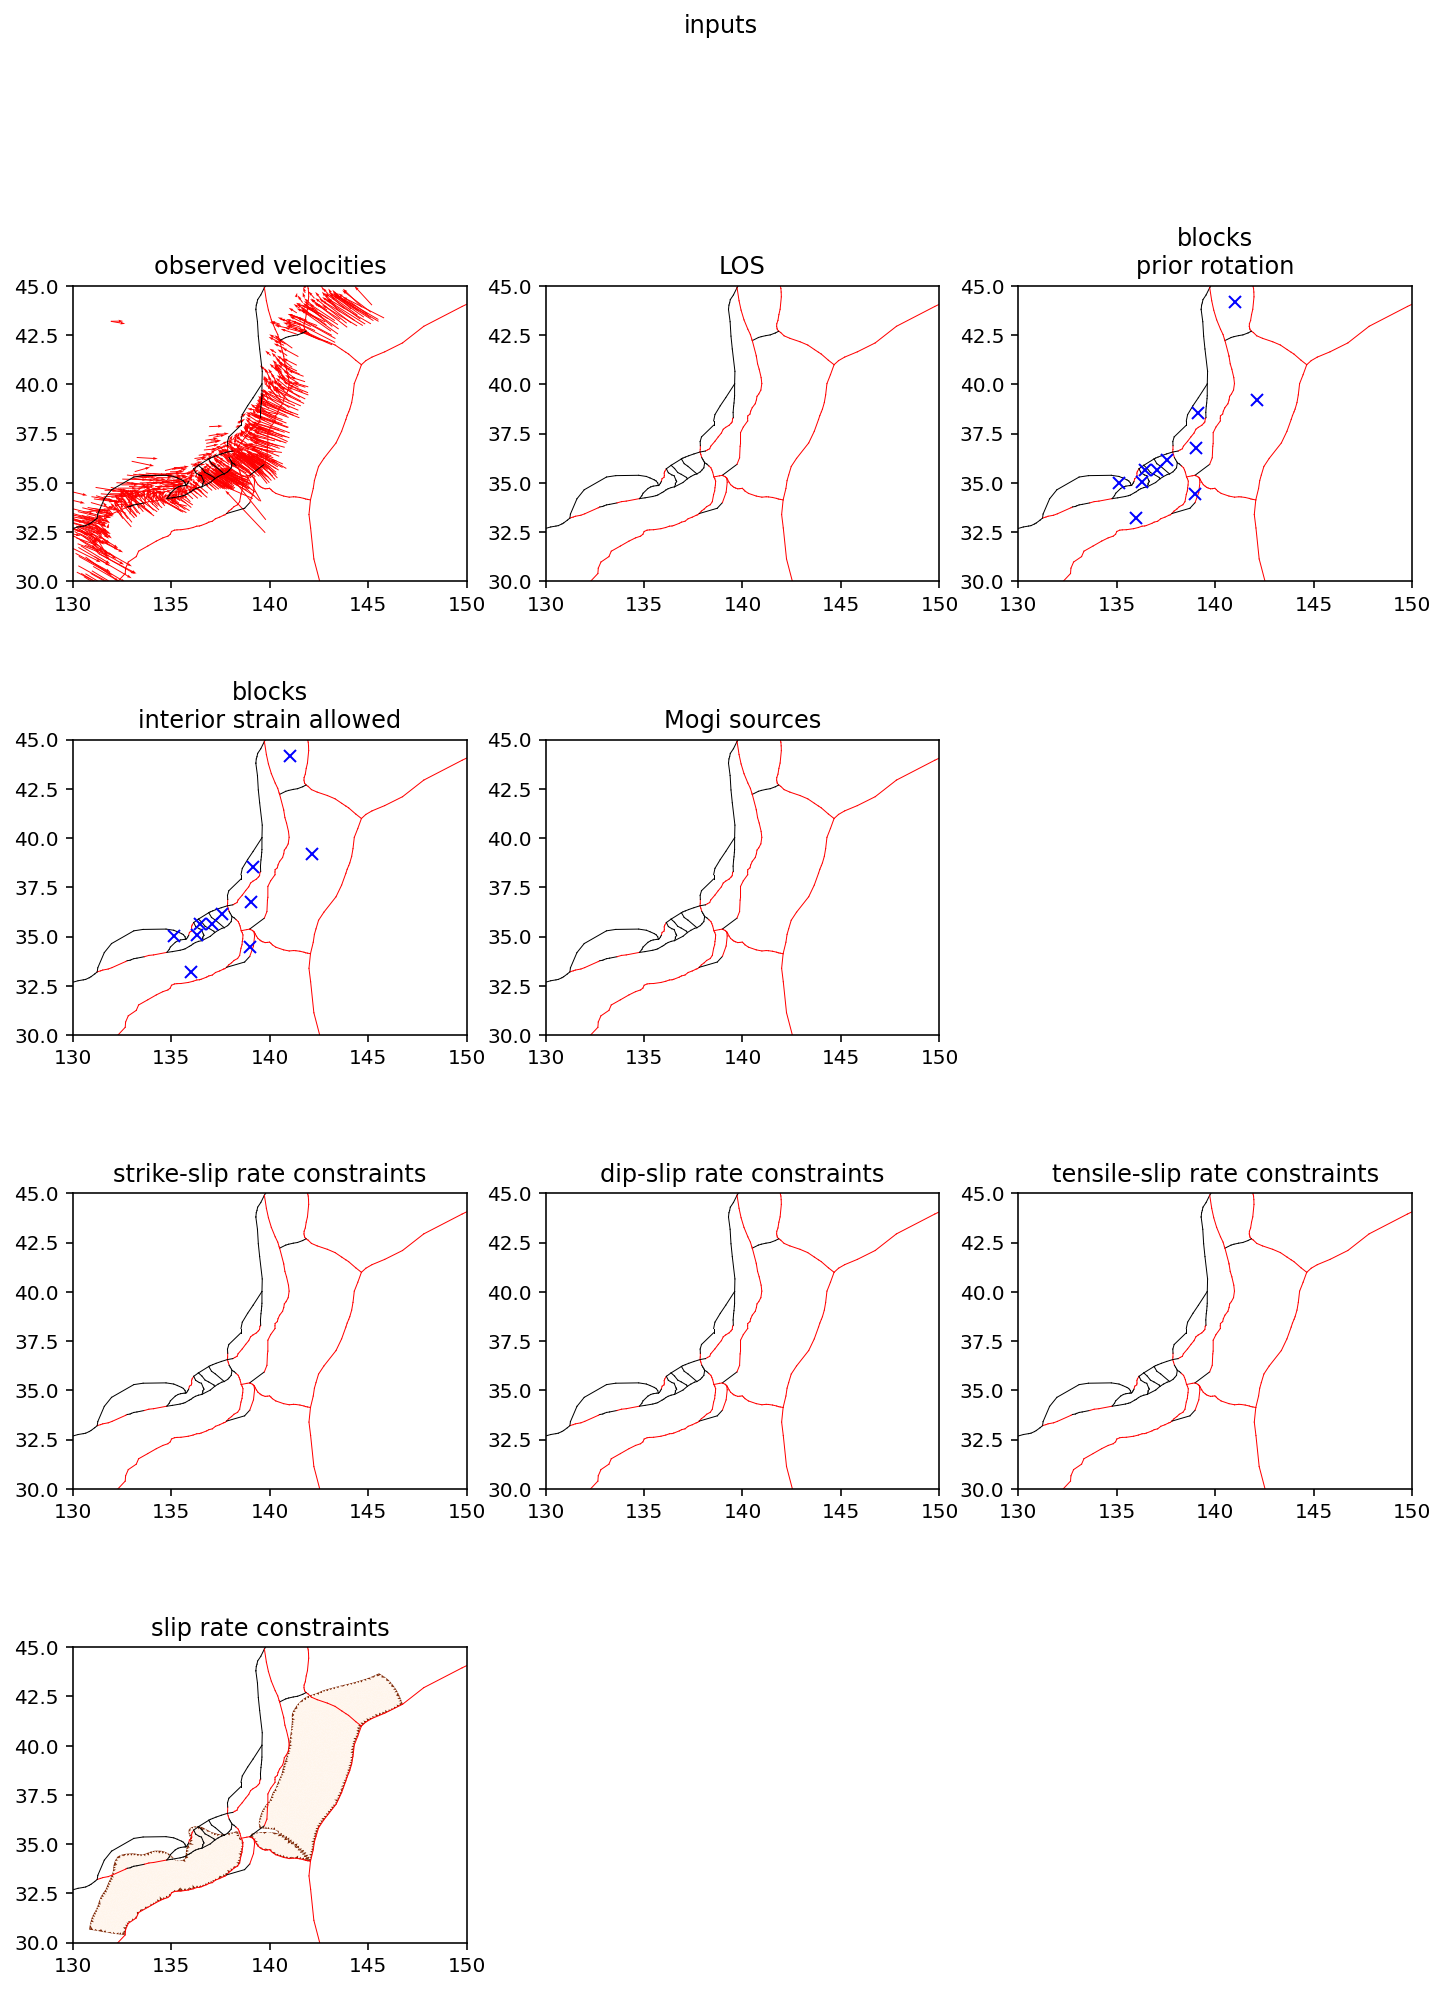

In [7]:
celeri.plot_input_summary(command, segment, station, block, meshes, mogi, sar, lon_range=command.lon_range, lat_range=command.lat_range, quiver_scale=command.quiver_scale)

# Calculate col_norms and H for each mesh here.

In [8]:
index = celeri.get_index(assembly, station, block, meshes)

# Data and data weighting vector
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
data_vector = celeri.get_data_vector(assembly, index)

# Apply data weighting
data_vector = data_vector * np.sqrt(weighting_vector)

# Cast all block submatrices to sparse
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

# Calculate column normalization vector for blocks
operator_block_only = celeri.get_full_dense_operator_block_only(operators, index)
weighting_vector_block_only = weighting_vector[0:operator_block_only.shape[0]][:, None]
col_norms = np.linalg.norm(operator_block_only * np.sqrt(weighting_vector_block_only), axis=0)

# Hmatrix decompositon for each TDE mesh
H, col_norms =  celeri.get_h_matrices_for_tde_meshes(command, meshes, station, operators, index, col_norms)


[INFO] Using precomputed elastic operators
[INFO] Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
[INFO] mesh 0 (../data/mesh/nankai.msh) H-matrix compression ratio: 0.5898
[INFO] Using precomputed elastic operators
[INFO] Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
[INFO] mesh 1 (../data/mesh/japan.msh) H-matrix compression ratio: 0.4711
[INFO] Using precomputed elastic operators
[INFO] Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
[INFO] mesh 2 (../data/mesh/sagami.msh) H-matrix compression ratio: 0.4884


In [9]:
# Package parameters that matvec and rmatvec need for the iterative solve
h_matrix_solve_parameters = (index,
                             meshes,
                             H,
                             operators,
                             weighting_vector,
                             col_norms,
                             sparse_block_motion_okada_faults,
                             sparse_block_motion_constraints,
                             sparse_block_slip_rate_constraints,
                             )

# Instantiate the scipy the linear operator for the iterative solver to use
operator_hmatrix = scipy.sparse.linalg.LinearOperator((index.n_operator_rows, index.n_operator_cols), matvec=celeri.matvec_wrapper(h_matrix_solve_parameters), rmatvec=celeri.rmatvec_wrapper(h_matrix_solve_parameters))

# Solve the linear system
sparse_hmatrix_solution = scipy.sparse.linalg.lsmr(operator_hmatrix, data_vector, atol=command.atol, btol=command.btol)

# Correct the solution for the col_norms preconditioning.
sparse_hmatrix_state_vector = sparse_hmatrix_solution[0] / col_norms


/Users/meade/Desktop/celeri/celeri/celeri.py:2704: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mesh_outputs = mesh_outputs.append(this_mesh_output)


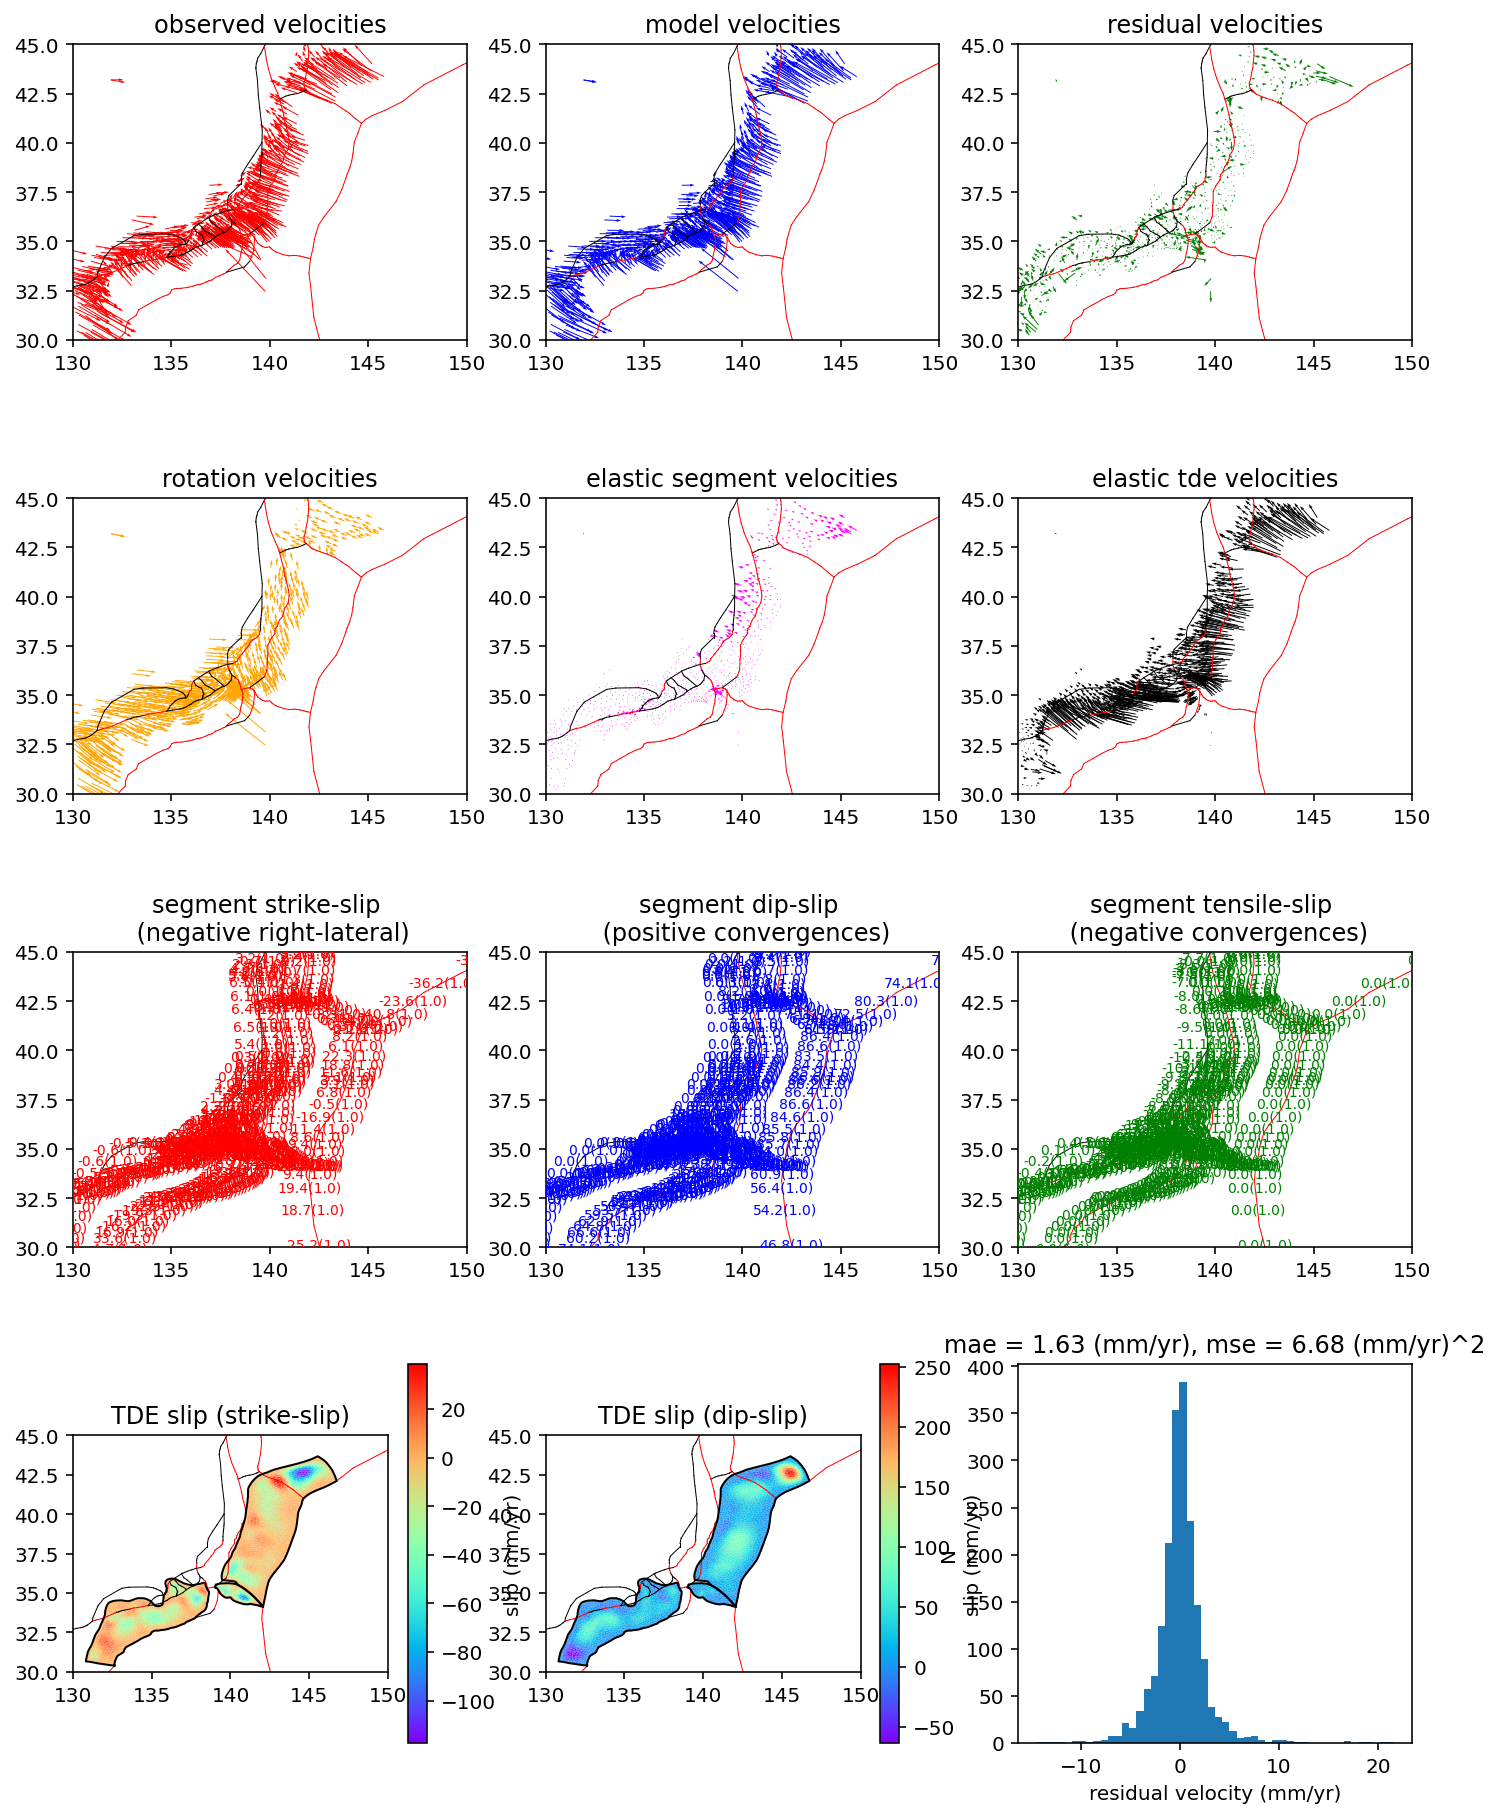

In [10]:
estimation = addict.Dict()
estimation.data_vector = data_vector
estimation.weighting_vector = weighting_vector
estimation.operator = operator_hmatrix
estimation.state_vector = sparse_hmatrix_state_vector
celeri.post_process_estimation_hmatrix(estimation, operators, meshes, H, station, index, col_norms, h_matrix_solve_parameters)
celeri.write_output(command, estimation, station, segment, block, meshes)
celeri.plot_estimation_summary(command, segment, station, meshes, estimation, lon_range=command.lon_range, lat_range=command.lat_range, quiver_scale=command.quiver_scale)
